In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy as sp
import itertools
import splitfolders
import zipfile,os
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Activation, Flatten, MaxPool2D
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.metrics import classification_report, confusion_matrix
import sklearn.metrics
import os
import random

In [2]:
# Load datasets
local_zip = 'rps.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('tmp')
zip_ref.close()

Split Datasets to 70% train, 25% validation, 5% test

In [3]:
# Split the dataset into training, validation, and test sets
splitfolders.ratio('C:\\Users\\USER\\PycharmProjects\\PrakML\\Code\\modul6\\tmp\\rps', output="C:\\Users\\USER\\PycharmProjects\\PrakML\\Code\\modul6\\tmp\\rockpaperscissors", seed=1337, ratio=(0.7, 0.25, 0.05))

# Define the directory paths
data_dir = 'C:\\Users\\USER\\PycharmProjects\\PrakML\\Code\\modul6\\tmp\\rockpaperscissors'
training_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

# Print the number of samples in each class
print("Number of paper samples in training set:", len(os.listdir(os.path.join(training_dir, 'paper'))))
print("Number of rock samples in training set:", len(os.listdir(os.path.join(training_dir, 'rock'))))
print("Number of scissors samples in training set:", len(os.listdir(os.path.join(training_dir, 'scissors'))))

# List the contents of the training and validation directories
print("Contents of the training directory:", os.listdir(training_dir))
print("Contents of the validation directory:", os.listdir(validation_dir))

Copying files: 2520 files [00:24, 103.53 files/s]

Number of paper samples in training set: 588
Number of rock samples in training set: 588
Number of scissors samples in training set: 588
Contents of the training directory: ['paper', 'rock', 'scissors']
Contents of the validation directory: ['paper', 'rock', 'scissors']


In [4]:
training_paper_dir = os.path.join(training_dir, 'paper')
training_rock_dir = os.path.join(training_dir, 'rock')
training_scissors_dir = os.path.join(training_dir, 'scissors')

validation_paper_dir = os.path.join(validation_dir, 'paper')
validation_rock_dir = os.path.join(validation_dir, 'rock')
validation_scissors_dir = os.path.join(validation_dir, 'scissors')

In [5]:
paper_imgs = os.listdir(training_paper_dir)
rock_imgs = os.listdir(training_rock_dir)
scissors_imgs = os.listdir(training_scissors_dir)

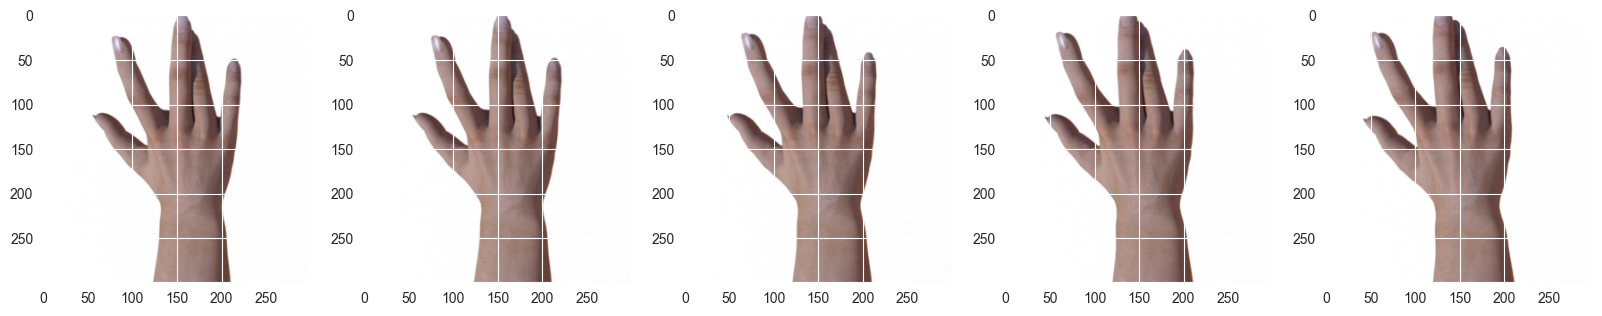

In [6]:
# Show sample image paper
plt.figure(figsize=(20, 4))
for i, img_path in enumerate(paper_imgs[:5]):
    sp = plt.subplot(1, 5, i+1)
    img = mpimg.imread(os.path.join(training_paper_dir, img_path))
    plt.imshow(img)
plt.show()

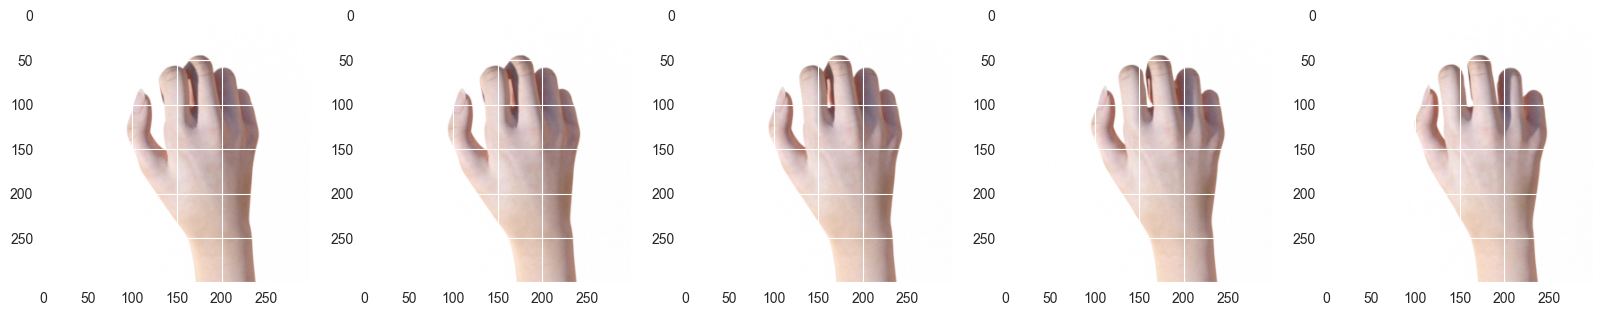

In [7]:
# Show sample image rock
plt.figure(figsize=(20, 4))
for i, img_path in enumerate(rock_imgs[:5]):
    sp = plt.subplot(1, 5, i+1)
    img = mpimg.imread(os.path.join(training_rock_dir, img_path))
    plt.imshow(img)
plt.show()

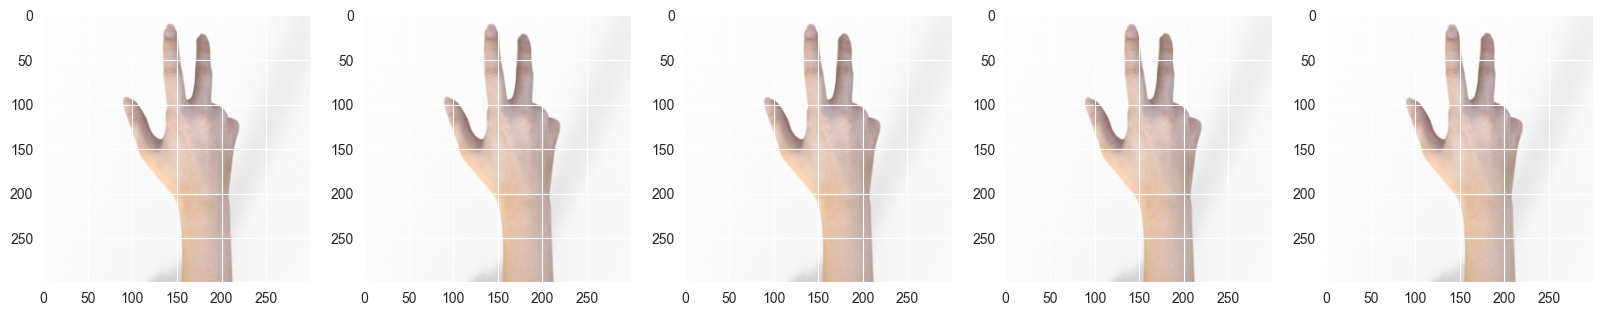

In [8]:
# Show sample image rock
plt.figure(figsize=(20, 4))
for i, img_path in enumerate(scissors_imgs[:5]):
    sp = plt.subplot(1, 5, i+1)
    img = mpimg.imread(os.path.join(training_scissors_dir, img_path))
    plt.imshow(img)
plt.show()

Augmentasi and  Dataset image

In [9]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.5, shear_range=0.2, zoom_range=0.2, rotation_range=20, horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.5)

In [10]:
train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=(100,100),
    classes=['paper', 'rock', 'scissors'],
    batch_size = 32,
    class_mode='categorical',
    shuffle=True
)

valid_generator= validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(100,100),
    classes=['paper', 'rock', 'scissors'],
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    subset='validation'
)

Found 1764 images belonging to 3 classes.
Found 315 images belonging to 3 classes.


In [11]:
train_generator.class_indices

{'paper': 0, 'rock': 1, 'scissors': 2}

In [12]:
valid_generator.class_indices

{'paper': 0, 'rock': 1, 'scissors': 2}

In [14]:
NUM_TRAIN_DATA = train_generator.n
NUM_VALID_DATA = valid_generator.n

In [15]:
model = Sequential()

model.add(Conv2D(16, kernel_size=3, activation='relu', input_shape=(100, 100, 3)))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.25))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.25))
model.add(Conv2D(128, kernel_size=3, activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 49, 49, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 23, 23, 32)        0

In [16]:
model.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator, steps_per_epoch=NUM_TRAIN_DATA//32, epochs=20, validation_data=valid_generator, validation_steps=5, verbose=2)

Epoch 1/20
55/55 - 32s - loss: 1.1893 - accuracy: 0.3684 - val_loss: 1.0278 - val_accuracy: 0.6938 - 32s/epoch - 582ms/step
Epoch 2/20
55/55 - 12s - loss: 0.7518 - accuracy: 0.6726 - val_loss: 0.2844 - val_accuracy: 0.9625 - 12s/epoch - 224ms/step
Epoch 3/20
55/55 - 12s - loss: 0.3886 - accuracy: 0.8412 - val_loss: 0.1309 - val_accuracy: 0.9563 - 12s/epoch - 224ms/step
Epoch 4/20
55/55 - 12s - loss: 0.2220 - accuracy: 0.9267 - val_loss: 0.0299 - val_accuracy: 0.9875 - 12s/epoch - 224ms/step
Epoch 5/20
55/55 - 12s - loss: 0.1652 - accuracy: 0.9463 - val_loss: 0.0755 - val_accuracy: 0.9625 - 12s/epoch - 221ms/step
Epoch 6/20
55/55 - 12s - loss: 0.1212 - accuracy: 0.9579 - val_loss: 0.0118 - val_accuracy: 1.0000 - 12s/epoch - 225ms/step
Epoch 7/20
55/55 - 13s - loss: 0.0945 - accuracy: 0.9694 - val_loss: 0.1019 - val_accuracy: 0.9625 - 13s/epoch - 234ms/step
Epoch 8/20
55/55 - 13s - loss: 0.0920 - accuracy: 0.9636 - val_loss: 0.0055 - val_accuracy: 1.0000 - 13s/epoch - 238ms/step
Epoch 9/

Model Evaluation

In [17]:
score = model.evaluate(train_generator)

print('Loss: {:.4f}'.format(score[0]))
print('Accuracy: {:.4f}'.format(score[1]))

56/56 [==============================] - 12s 204ms/step - loss: 0.0043 - accuracy: 0.9994
Loss: 0.0043
Accuracy: 0.9994


In [18]:
score = model.evaluate(valid_generator)

print('Loss: {:.4f}'.format(score[0]))
print('Accuracy: {:.4f}'.format(score[1]))

10/10 [==============================] - 2s 174ms/step - loss: 0.0100 - accuracy: 0.9937
Loss: 0.0100
Accuracy: 0.9937


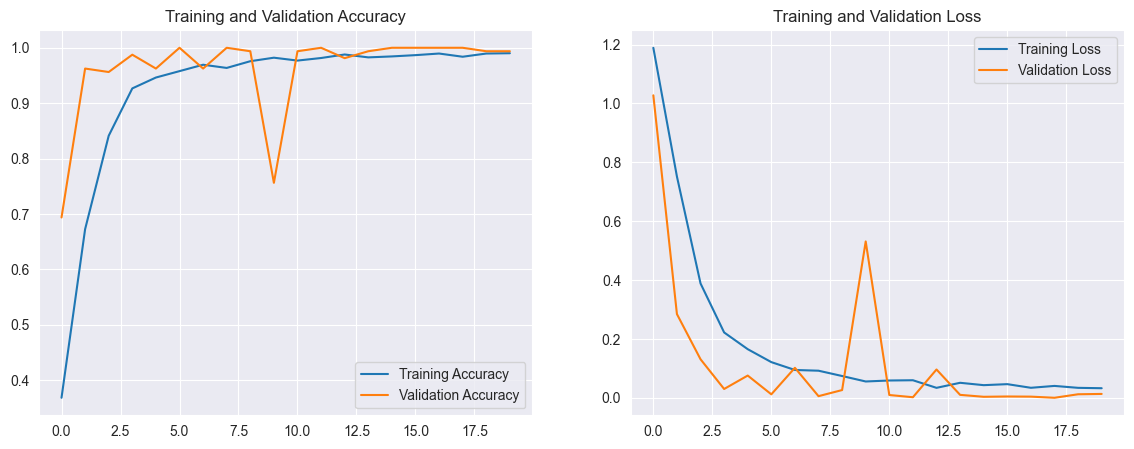

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Save Model

In [21]:
# Save the model in h5 format
model.save('model_CNN.h5')

# Save the model architecture in json format
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open("model.tflite", "wb") as tflite_file:
    tflite_file.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\USER\AppData\Local\Temp\tmphuux8aqj\assets


INFO:tensorflow:Assets written to: C:\Users\USER\AppData\Local\Temp\tmphuux8aqj\assets


Confusion Matrix

10/10 [==============================] - 1s 88ms/step


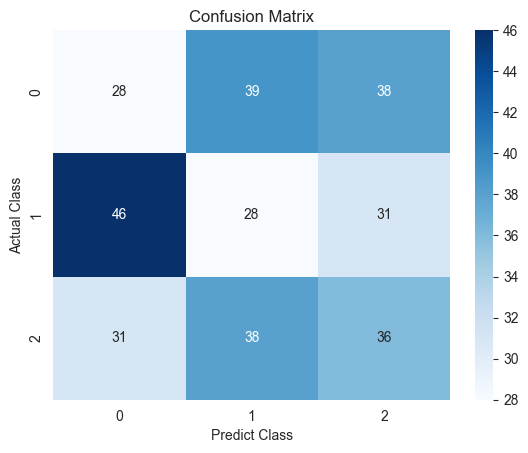

True Negative =  28
False Negative =  46
True Positive =  28
False Positive =  39


In [42]:
import seaborn as sns

Batch_size = 32

Y_prediction = model.predict(valid_generator, NUM_VALID_DATA//Batch_size+1)
y_prediction = np.argmax(Y_prediction, axis=1)

conf_matrix = confusion_matrix(valid_generator.classes, y_prediction)
confusion_array = sklearn.metrics.confusion_matrix(valid_generator.classes, y_prediction)

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel('Actual Class')
plt.xlabel("Predict Class")
plt.show()

print('True Negative = ', confusion_array[0,0])
print('False Negative = ', confusion_array[1,0])
print('True Positive = ', confusion_array[1,1])
print('False Positive = ', confusion_array[0,1])

Classification Report

In [43]:
print('Classification Report Validation')
target_names = ['Paper', 'Rock', 'Scissors']
print(classification_report(valid_generator.classes, y_prediction, target_names=target_names))

Classification Report Validation
              precision    recall  f1-score   support

       Paper       0.27      0.27      0.27       105
        Rock       0.27      0.27      0.27       105
    Scissors       0.34      0.34      0.34       105

    accuracy                           0.29       315
   macro avg       0.29      0.29      0.29       315
weighted avg       0.29      0.29      0.29       315



In [44]:
import os
import shutil

# Define the paths to the test directory and its subdirectories
test_dir = 'C:\\Users\\USER\\PycharmProjects\\PrakML\\Code\\modul3\\tmp\\rockpaperscissors\\test'
paper_dir = os.path.join(test_dir, 'paper')
rock_dir = os.path.join(test_dir, 'rock')
scissors_dir = os.path.join(test_dir, 'scissors')

# Define the target directory where you want to merge the images
target_dir = os.path.join(test_dir, 'merged_test')

# Create the target directory if it doesn't exist
if not os.path.exists(target_dir):
    os.makedirs(target_dir)

# List the files in each subdirectory and move them to the target directory
for subdir in [paper_dir, rock_dir, scissors_dir]:
    for filename in os.listdir(subdir):
        source_path = os.path.join(subdir, filename)
        target_path = os.path.join(target_dir, filename)
        shutil.copy(source_path, target_path)

Predict Test set

In [49]:
def get_class(file_name):
    # Split the file path by both forward and backward slashes
    path_components = file_name.split('/')
    path_components.extend(file_name.split('\\'))  # Extend the list with backslash splits

    # Find the last component that is not empty and use it as the class label
    for component in reversed(path_components):
        if component:
            return component
    # Return a default label if the path does not contain a valid class label
    return 'Unknown'

Found 126 images belonging to 3 classes.
1/1 [==============================] - 0s 34ms/step


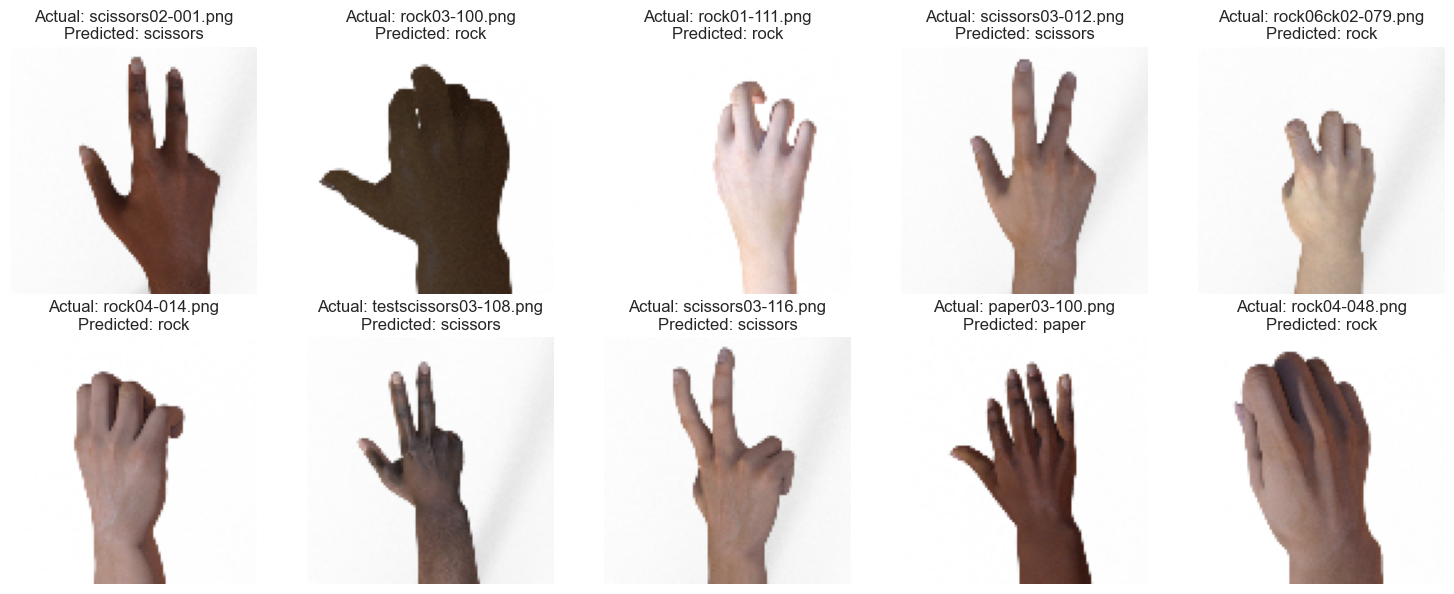

In [50]:
# Load test set
test_dir = 'C:\\Users\\USER\\PycharmProjects\\PrakML\\Code\\modul3\\tmp\\rockpaperscissors\\test'
test_files = os.listdir(test_dir)

# preprocess the selected images

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

selected_test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(100,100),
    batch_size=32,
    class_mode='categorical',
    classes=['paper','rock', 'scissors'],
    shuffle=False
)
random_numbers = [random.randint(0, 126 - 1) for _ in range(10)]
class_labels = list(selected_test_generator.class_indices.keys())

num_rows = 2
num_cols = 5

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 6))

for i, ax in enumerate(axes.flat):
    img_path = selected_test_generator.filepaths[random_numbers[i]]
    img = cv2.imread(img_path)
    img = cv2.resize(img, (100, 100))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    prediction = model.predict(img.reshape(1, 100, 100, 3))
    predicted_label = class_labels[np.argmax(prediction)]

    actual_label = get_class(img_path)

    ax.imshow(img)
    ax.set_title(f'Actual: {actual_label}\nPredicted: {predicted_label}')
    ax.axis('off')

plt.tight_layout()
plt.show()